In [49]:
'''
Notes:
- Notebook adapted from 'PSS4E6 EDA which makes sense' by Ambrosm, (https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense#Ensembles)
''';

In [50]:
'''
Contents
1. Package imports
2. Data import and pre-processing
    2.1. Data import
    2.2. Print basic 
    2.3. Visualise target breakdown
    2.4. Define categorical and continuous features
    2.5. Convert categorical features to 'category' dtype
3. EDA
    3.1. Display feature histogram
    3.2. Plot histogram for particular feature for training vs test set
    3.3. Calculate Mann-Whitney U test pvalue
    3.4. Calculate and visualise the most important features using a DecisionTreeClassifier(thereby training dt_model)
    3.5. Calculate and visualise the univariate ranking
    3.6. Make provisional predictions on the test set using dt_model (save to 'submission_provisional.csv')
4. Modeling
    4.1. Configure StratifiedKFold and define global variables for oof, test predictions and oof-scores
    4.2. cross_validate() function
    4.3. Define model hyperparameters
        4.3.1. ExtraTreeClassifier - et_params1, et_params2
        4.3.2. RandomForestClassifier - rm_params1, rm_params2
        4.3.3. XGBClassifier - xgb_params1, xgb_params2, xgb_params3, xgb_params4
        4.3.4. LGBMClassifier - lgbm_params1, lgbm_params2
        4.3.5. CatBoostClassifier - cb_params
        4.3.6. LGBMClassifier (boosthing_type='dart') - dart_params
        4.3.7. LogisticRegression
            - This one requires a sklearn Pipeline class that takes a list of estimator object as pipeline steps, (1) ColumnTransformer, (2) StandardScaler, (3) LogisticRegression
5. Ensembling
    5.1. Define ensemble techniques
        5.1.1. Hard voting (not yet implemented)
        5.1.2. Ridge
        5.1.3. Logistic
    5.2. Evaluate ensembling methods
6. Submission
    6.1. Collect pre-calculated test predictions using cross_val_predict()
    6.2. Create submission .csv files for each ensembling technique
''';

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import numpy as np

# tick locating and formatting, MaxNLocator finds the max number of intervals with ticks at nice locations
from matplotlib.ticker import MaxNLocator

# statistical data visualisation base on matplotlib
import seaborn as sns

# eXtreme gradient boosting
import xgboost

# gradient boosting framework that uses tree based learning algorithms (designed by Microsoft)
import lightgbm

# graident boosting on decision trees library (developed by Yandex)
import catboost
from datetime import datetime

# serialisation and de-serialisation of Python object structures, "pickling"
import pickle
import warnings

# mannwhitney performs the Mann-Whitney test, a nonparametric test of the null hypothesis
from scipy.stats import mannwhitneyu

# scipy.special contains special mathematical functions such as gamma, beta, erf etc.
import scipy.special

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, SplineTransformer, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, accuracy_score
from sklearn.calibration import CalibrationDisplay
from sklearn.feature_selection import mutual_info_classif

warnings.filterwarnings('ignore')

number of features: 36
entries in training set: 76518
entries in testing set:  51012


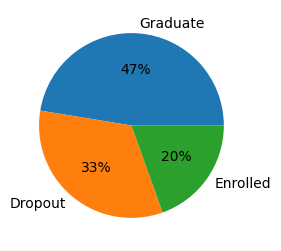

In [52]:
# define the base path to the dataset directory
data_path = 'playground_series/s04e06_classification_with_an_academic_success_dataset/data/'

# construct file paths for the training and testing datasets using os.path.join for system-independent path handling
train_path = os.path.join(data_path,'train.csv')
test_path  = os.path.join(data_path, 'test.csv')

#load the training and testing dataset. set the 'id' column as the index of the DataFrame
df_train = pd.read_csv(train_path, index_col='id')
df_test = pd.read_csv(test_path, index_col='id')

# retrieve and store the list of feastures from the test dataset
target_feature = 'Target'
initial_features = list(df_test.columns)

# display basic statistics: number of features and entreis in each dataset
print(f'number of features: {len(initial_features)}')
print(f'entries in training set: {len(df_train)}')
print(f'entries in testing set:  {len(df_test)}')

# visualise the distribution of the target variable in the training dataset 
def visualise_target_distribution(df):
    temp = df['Target'].value_counts()
    plt.figure(figsize=(3,3))
    plt.pie(temp, labels=temp.index, autopct='%.0f%%')
    plt.show()
visualise_target_distribution(df_train)

In [53]:
# initialize a LabelEncoder object to transform non-numeric tabels into numerical labels
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(df_train['Target'])

In [54]:
# list of categorical features in the dataset
cat_features = ['Marital status',
                'Application mode',
                'Course',
                'Previous qualification',
                'Nacionality',
                "Mother's qualification",
                "Father's qualification",
                "Mother's occupation",
                "Father's occupation"]

# list of continuouse features in the dataset
def get_cont_features(initial_features, cat_features):
    '''
    Create a list of continuous features, from lists of the initial features and the categorical features
    '''
    cont_features = []
    for feat in initial_features:
        if feat not in cat_features:
            cont_features.append(feat)
    return cont_features
cont_features = get_cont_features(initial_features, cat_features)

def convert_cat_dtypes(df, features):
    '''
    Convert specified columns in a DataFrame to categorical data types.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        features (list of str): A list of column naes to be converted to categorical type.

    Returns:
        pd.DataFrane: The DataFrame with the specified columns converted to categorical types.
    '''
    df = df.copy()
    for feature in features:
        # dtype = pd.CategoricalDtype(categories=list(set(df[feature])), ordered=False)
        # df[feature] = df[feature].astype(dtype)
        df[feature] = df[feature].astype('category')

    return df

df_train = convert_cat_dtypes(df_train, cat_features)
df_test = convert_cat_dtypes(df_test, cat_features)

In [55]:
# check whether categorical features have been correctly set as categorical
for feature in cat_features:
    for df in df_train, df_test:
        assert df[feature].dtype.name == 'category', f"{feature} is not categorical in df"

        if df[feature].dtype.name != 'category':
            print(f"{feature} in df not correctly set to dtype 'category'")

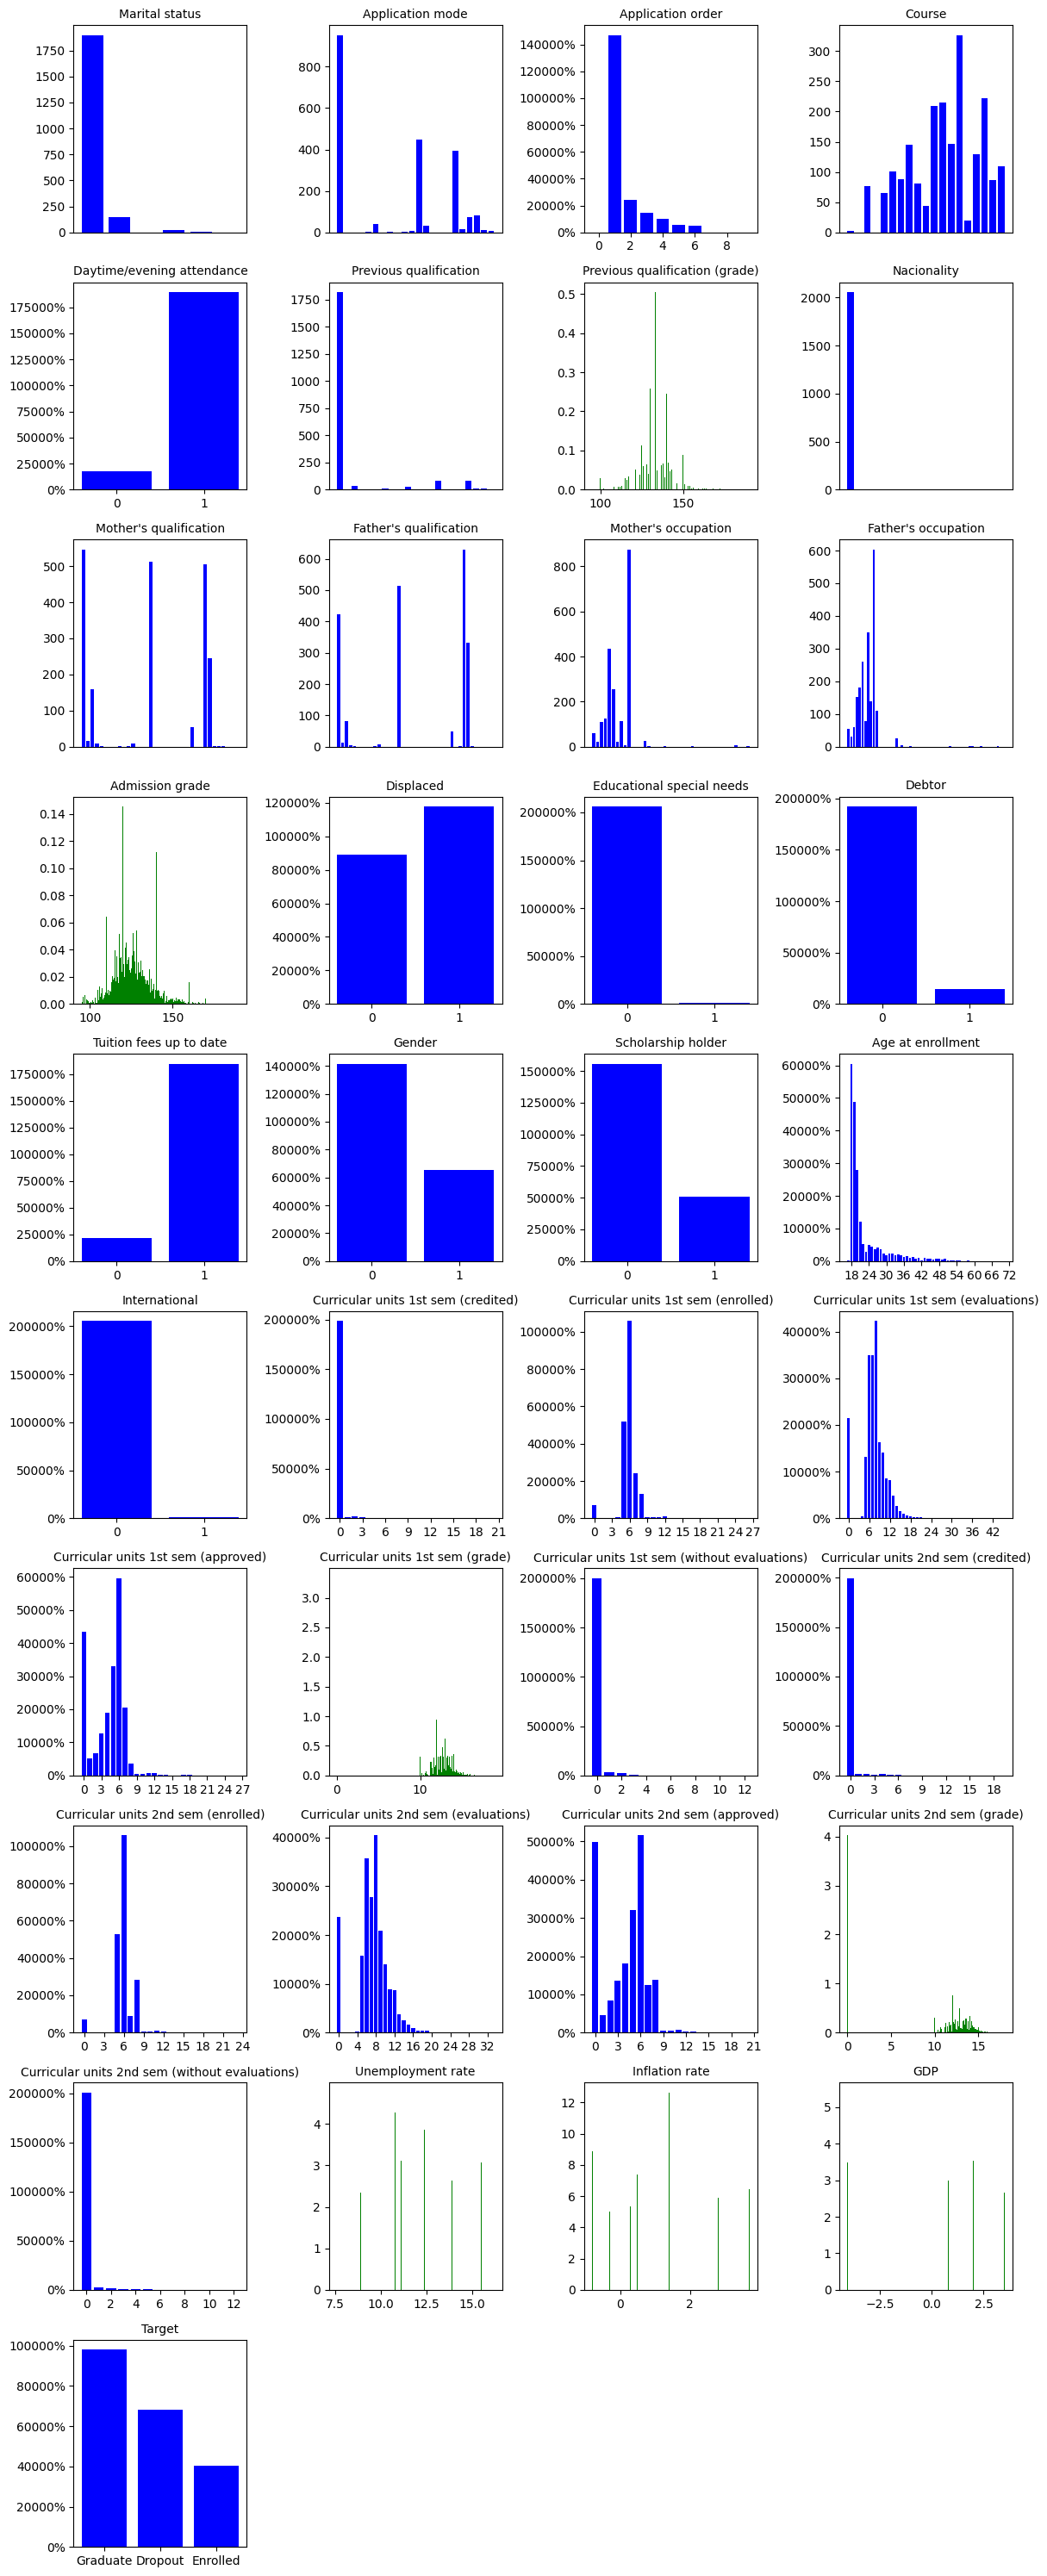

In [56]:
def display_feature_graphs(df, features=None):
    '''
    Display histograms or bar charts for each feature in the given DataFrame.

    Args:
        df (DataFrame): The DataFrame containing the features to be plotted.
        features (list of str, optional): List of column names to plot. Plots all columns if None.
    
    Generates a grid of plots with histograms for numerical features and bar charts for categorical features.
    '''
    if features is None:
        features = df.columns.tolist()

    num_features = len(features)
    num_rows = (num_features + 3) // 4

    fig, axs = plt.subplots(num_rows, 4, figsize=(12, max(20, 3 * num_rows)))
    axs = axs.ravel()

    for col, ax in zip(features, axs):
        if df[col].dtype == float:
            ax.hist(df[col], bins=300, density=True, color='g')
        elif df[col].dtype == 'category':
            vc = df[col].cat.codes.value_counts() / num_features
            ax.bar(vc.index, vc, color='b')
            ax.set_xticks([])
        else:
            vc = df[col].value_counts() / num_features
            ax.bar(vc.index, vc, color='b')
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_formatter('{x:.0%}')
        ax.set_title(col, fontsize=10)

    for idx in range(num_features, len(axs)):
        fig.delaxes(axs[idx])  # Remove unused axes
        
    plt.tight_layout()
    plt.show()
display_feature_graphs(df_train)

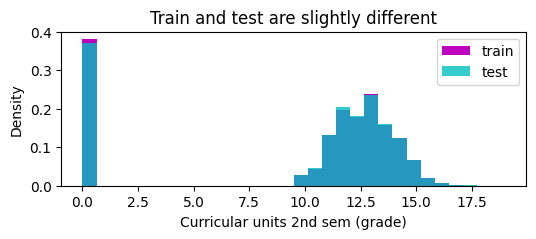

In [57]:
def plot_histogram_comparison(df1, df2, column_name, label1, label2, title, alpha=0.8):
    """
    Plot overlaid histograms for the specified column from two different DataFrames.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        column_name (str): The column name to plot the histograms for.
        label1 (str): Label for the histogram of the first DataFrame.
        label2 (str): Label for the histogram of the second DataFrame.
        title (str): Title for the plot.
        alpha (float, optional): Transparency for the second histogram. Default is 0.8.

    This function creates a plot with two overlaid histograms, useful for comparing the
    distribution of a specific feature across two different datasets. The histograms
    are normalized to show density instead of counts to facilitate comparison.
    """

    plt.figure(figsize=(6, 2))

    # Plot histogram for the first dataset
    plt.hist(df1[column_name],
             bins=np.linspace(0, 19, 31),
             density=True,
             color='m',
             label=label1)

    # Plot histogram for the second dataset
    plt.hist(df2[column_name],
             bins=np.linspace(0, 19, 31),
             density=True,
             alpha=alpha,
             color='c',
             label=label2)

    # Setting labels and titles
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage of the function:
plot_histogram_comparison(df_train, df_test, 'Curricular units 2nd sem (grade)', 'train', 'test', 'Train and test are slightly different')

In [58]:
# formally compare the train and test distributions with the Mann-Whitney U test
def print_MWU_pvalue(df_train, df_test, feature=None):
    feature = initial_features[0] if feature is None else feature
    stat, p_value = mannwhitneyu(df_train[feature], df_test[feature])
    print((f'Mann-Whitney U test comparing train and test datasets'))
    print(f'Feature: {feature}')
    print(f'p_value: {p_value:.03f}')
    return stat, p_value

print_MWU_pvalue(df_train, df_test, feature='Curricular units 2nd sem (grade)');

Mann-Whitney U test comparing train and test datasets
Feature: Curricular units 2nd sem (grade)
p_value: 0.064


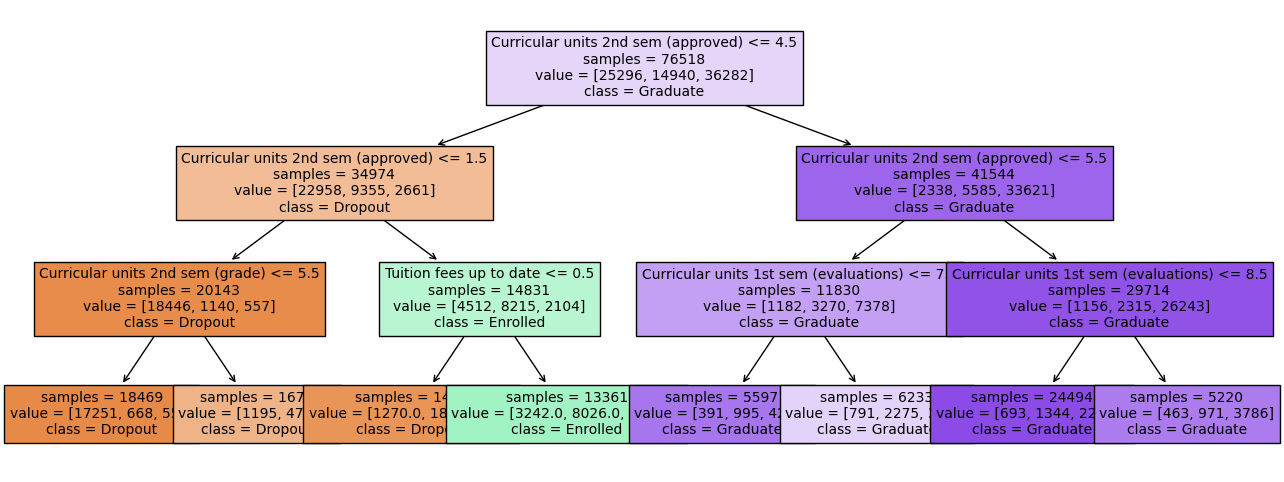

In [59]:
def most_important_features(df, initial_features, target_feature, label_encoder, depth=3, visualise=True):
    '''
    Plots the most important features of a DecisionTreeClassifier fitterd on the given dataframe.

    Paraeters:
        df (pd.DataFrame): The dataframe containing the features and target variable.
        initial_features (list of str): List of feature names to be used for training the model.
        target_feature (str): The name of the target variable
        label_encode (LabelEncoder): An encoder for the target variable classes.
        depth (int, optional): The maximum depth of the decision tree. Default is 3.

    Returns:
        None
    '''
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(df[initial_features], df[target_feature])

    if visualise:
        plt.figure(figsize=(16,6))
        plot_tree(dt,
                feature_names=initial_features,
                class_names=label_encoder.classes_,
                fontsize=10,
                impurity=False,
                filled=True,
                ax=plt.gca())
        plt.show()
    
    return dt

dt_model = most_important_features(df_train, initial_features, target_feature, label_encoder, depth=3)

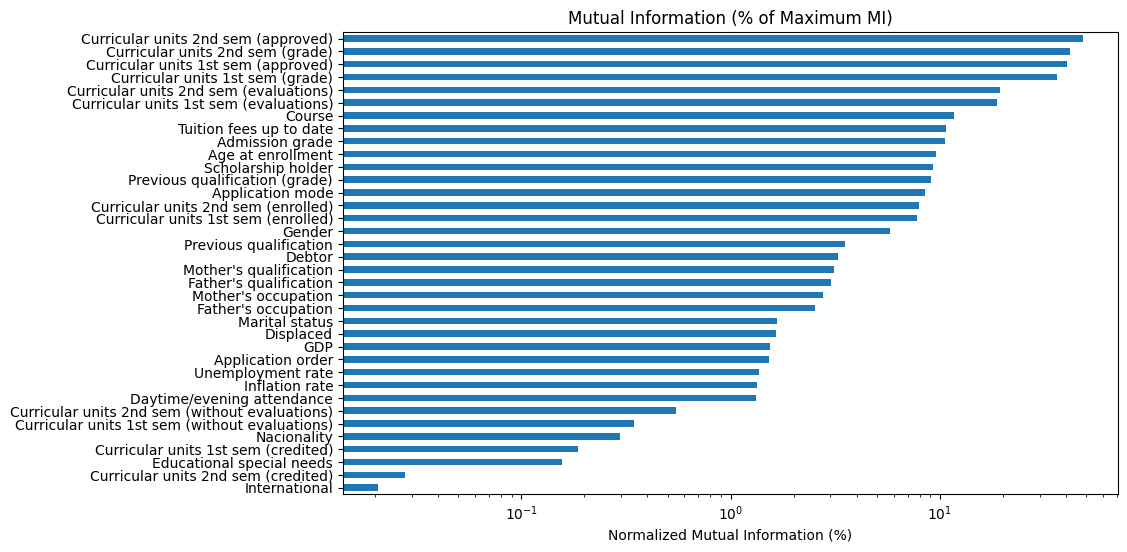

In [60]:
def univariate_ranking(df):
    '''
    Ranks features in a dataframe based on their normalized mutual information with a categorical target variable.
    
    The function computes the mutual information between each feature and the target, normalizes these values by the
    target's entropy, and plots the average normalized mutual information scores across multiple runs as a horizontal bar chart.
    
    Parameters:
    - df (pandas.DataFrame): A dataframe containing features and a target column named 'Target'.
    
    Returns:
    - None: Displays a horizontal bar chart of the features ranked by the normalized mutual information.
    '''
    X = df
    y = LabelEncoder().fit_transform(X.pop('Target'))

    # compute the mutual information for each feature
    mutual_infos = pd.Series(dtype=float)
    for i in range(5):
        mi_scores = mutual_info_classif(X, y, random_state=i)
        mutual_infos = mutual_infos.add(pd.Series(mi_scores, index=X.columns), fill_value=0)

    # normalize by the average mutual information (assuming averaging across random states)
    normalized_mi = mutual_infos/5

    ax = (normalized_mi*100).sort_values(ascending=False).plot(kind='barh', figsize=(10, 6), logx=True)
    ax.invert_yaxis()
    ax.set_title('Mutual Information (% of Maximum MI)')
    plt.xlabel('Normalized Mutual Information (%)')
    plt.show()

univariate_ranking(df_train)

In [61]:
predictions = dt_model.predict(df_test[initial_features])
submission_df = pd.DataFrame({
    'id': df_test.index,
    'Target': predictions
})

submission_df.to_csv('submission.csv', index=False)

In [18]:
# configuration for stratified k-fold cross-validation
crossval_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# global dictionaries to store out-of-fold predictions, test predictions and fold scores
oof, test_pred, fold_scores = {}, {}, {}

# flat to determine if test predictions should be computed
compute_test_pred = True

In [19]:
def cross_validate(model, label, features=initial_features, verbose=True):
    '''
    Performs stratified k-fold cross-validation on the given model and dataset.

    Args:
        model (model object): The machine learning model to train and validate.
        label (str): Label used to identify the model in output dictionaries.
        features (list): List of feature colun names used for training.

    Scores:
        Out-of-fold predictions in the global dictionary `oof`.
        Test predictions in the global dictionary `test_pred`.
        Accuracy scores for each fold in the global dictionary `fold_scores`.
    '''
    t0 = datetime.now()

    scores = []
    oof_preds = np.full((len(df_train), 3), np.nan, dtype=float)

    # iterate over each fold
    for fold, (index_train, index_val) in enumerate(crossval_kf.split(df_train, targets)):
        
        # create fold training and validation data
        X_train = df_train.iloc[index_train][features]
        X_val = df_train.iloc[index_val][features]
        y_train = targets[index_train]
        y_val = targets[index_val]

        # fit model to training data fold
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)

        # calculate the accuracy score for the current fold
        score = accuracy_score(y_val, np.argmax(y_pred, axis=1))
        
        scores.append(score)
        oof_preds[index_val] = y_pred

        if verbose:
            print(f'Fold #: {fold}; accuracy = {score:.5f}')

    # calculate overall metrics for all folds processed
    t1 = datetime.now()
    mins = int(np.round((t1-t0).total_seconds()/60))
    secs = int(np.round((t1-t0).total_seconds()%60))
    accuracy = accuracy_score(targets, np.argmax(oof_preds, axis=1))
    logloss = log_loss(targets, oof_preds)

    if verbose:
        print(f'Overall: accuracy={accuracy:.5f}; logloss={logloss:.5f}; label={label}')
        print(f'Time elapsed = {mins} min, {secs} seconds')

    # store results in global variables
    oof[label] = oof_preds
    fold_scores[label] = scores

    if compute_test_pred:
        X_train = df_train[features]
        y_train = targets

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(df_test[features])
        test_pred[label] = y_pred

In [199]:
# model: ExtraTrees 1

# model parameters
et_params = {
    'min_samples_leaf': 1,
    'max_features': 0.4228007626245592,
    'min_impurity_decrease': 4.004184188705882e-05,
    'n_estimators': 100,
    'criterion': 'log_loss'
}

# initialize and train the model using the cross_validate function
model = ExtraTreesClassifier(**et_params)
cross_validate(model, 'ExtraTrees 1', initial_features)

Fold #: 0; accuracy = 0.82116
Fold #: 1; accuracy = 0.82933
Fold #: 2; accuracy = 0.81959
Fold #: 3; accuracy = 0.82971
Fold #: 4; accuracy = 0.82513
Overall: accuracy=0.82498; logloss=0.45345; label=ExtraTrees 1
Time elapsed = 0 min, 25 seconds


In [200]:
# model: ExtraTrees 2

# model parameters
et_params = {
    'min_samples_leaf': 4,
    'max_features': 0.42393862999688375,
    'min_impurity_decrease': 5.314080269075048e-06,
    'n_estimators': 100,
    'criterion': 'log_loss'
}

# initialize and train the model using the cross_validate function
model = ExtraTreesClassifier(**et_params)
cross_validate(model, 'ExtraTrees 2', initial_features)

Fold #: 0; accuracy = 0.82005
Fold #: 1; accuracy = 0.82965
Fold #: 2; accuracy = 0.81926
Fold #: 3; accuracy = 0.82853
Fold #: 4; accuracy = 0.82592
Overall: accuracy=0.82468; logloss=0.46411; label=ExtraTrees 2
Time elapsed = 0 min, 28 seconds


In [201]:
# model: Random forest 1

# model parameters
rf_params = {
    'n_estimators': 400,
    'min_impurity_decrease': 1e-6
}

model = RandomForestClassifier(**rf_params)
cross_validate(model, 'Random forest 1')

Fold #: 0; accuracy = 0.82318
Fold #: 1; accuracy = 0.83116
Fold #: 2; accuracy = 0.82246
Fold #: 3; accuracy = 0.83082
Fold #: 4; accuracy = 0.82637
Overall: accuracy=0.82680; logloss=0.45461; label=Random forest 1
Time elapsed = 2 min, 49 seconds


In [202]:
# model: Random forest 2

# model parameters
rf_params = {
    'min_samples_leaf': 2, 
    'max_features': 0.6678943947450321,
    'min_impurity_decrease': 0.00014125090018120894,
    'max_samples': 0.8660526124724528,
    'n_estimators': 400,
    'criterion': 'log_loss'
}

model = RandomForestClassifier(**rf_params)
cross_validate(model, 'Random forest 2')

Fold #: 0; accuracy = 0.82253
Fold #: 1; accuracy = 0.83076
Fold #: 2; accuracy = 0.82005
Fold #: 3; accuracy = 0.82918
Fold #: 4; accuracy = 0.82664
Overall: accuracy=0.82583; logloss=0.44989; label=Random forest 2
Time elapsed = 4 min, 7 seconds


In [203]:
# model: XGBoost untuned

# model parameters
xgb_params = {
    'enable_categorical': True,
    'tree_method': 'hist'
}

model = xgboost.XGBClassifier(**xgb_params)
cross_validate(model, 'XGBoost untuned')

Fold #: 0; accuracy = 0.82678
Fold #: 1; accuracy = 0.83416
Fold #: 2; accuracy = 0.82730
Fold #: 3; accuracy = 0.83395
Fold #: 4; accuracy = 0.82892
Overall: accuracy=0.83022; logloss=0.44183; label=XGBoost untuned
Time elapsed = 0 min, 3 seconds


In [204]:
# model: XGBoost tuned 1

# model parameters
xgb_params = {
    'grow_policy': 'depthwise',
    'tree_method': 'hist',
    'enable_categorical': True,
    'gamma': 0,
    'n_estimators': 768,
    'learning_rate': 0.026111403303690425,
    'max_depth': 8,
    'reg_lambda': 26.648168065161098,
    'min_child_weight': 1.0626186255116183,
    'subsample': 0.8580490989206254,
    'colsample_bytree': 0.5125814118774029
}

model = xgboost.XGBClassifier(**xgb_params)
cross_validate(model, 'XGBoost tuned 1')

Fold #: 0; accuracy = 0.82998
Fold #: 1; accuracy = 0.83802
Fold #: 2; accuracy = 0.83181
Fold #: 3; accuracy = 0.83696
Fold #: 4; accuracy = 0.83271
Overall: accuracy=0.83390; logloss=0.43091; label=XGBoost tuned 1
Time elapsed = 1 min, 38 seconds


In [205]:
# model: XGBoost tuned 2

# model parameters
xgb_params = {
    'grow_policy': 'depthwise',
    'learning_rate': 0.06150883051411711,
    'n_estimators': 822,
    'max_depth': 5,
    'reg_lambda': 12.695544291635334,
    'min_child_weight': 25.289808052903343,
    'subsample': 0.9831949009517902,
    'colsample_bytree': 0.2687930272243655,
    'tree_method': 'hist',
    'enable_categorical': True,
    'gamma': 0.68179
}

model = xgboost.XGBClassifier(**xgb_params)
cross_validate(model, 'XGBoost tuned 2.1')

Fold #: 0; accuracy = 0.82750
Fold #: 1; accuracy = 0.83775
Fold #: 2; accuracy = 0.83142
Fold #: 3; accuracy = 0.83761
Fold #: 4; accuracy = 0.83415
Overall: accuracy=0.83369; logloss=0.42986; label=XGBoost tuned 2.1
Time elapsed = 0 min, 15 seconds


In [206]:
# model: XGBoost tuned 3

# model parameters
xgb_params = {
    'grow_policy': 'depthwise',
    'learning_rate': 0.04104089631389812,
    'n_estimators': 1311,
    'max_depth': 5,
    'reg_lambda': 29.548955808402486,
    'min_child_weight': 17.58377776073493,
    'subsample': 0.9141573846486278,
    'colsample_bytree': 0.4000772723424121,
    'tree_method': 'hist',
    'enable_categorical': True,
    'gamma': 0
}

model = xgboost.XGBClassifier(**xgb_params)
cross_validate(model, 'XGBoost tuned 3')

Fold #: 0; accuracy = 0.82972
Fold #: 1; accuracy = 0.83795
Fold #: 2; accuracy = 0.83194
Fold #: 3; accuracy = 0.83689
Fold #: 4; accuracy = 0.83343
Overall: accuracy=0.83399; logloss=0.42961; label=XGBoost tuned 3
Time elapsed = 1 min, 34 seconds


In [207]:
# model: LightGBM untuned
 
# model parameters
lgbm_params = {
    'verbose': -1
}

model = lightgbm.LGBMClassifier(**lgbm_params)
cross_validate(model, 'LightGBM untuned')
# Overall: accuracy=0.83282 logloss=0.43358 LightGBM untuned   1 min

Fold #: 0; accuracy = 0.82678
Fold #: 1; accuracy = 0.83723
Fold #: 2; accuracy = 0.82652
Fold #: 3; accuracy = 0.83441
Fold #: 4; accuracy = 0.83226
Overall: accuracy=0.83144; logloss=0.43550; label=LightGBM untuned
Time elapsed = 0 min, 3 seconds


In [208]:
# model: LightGBM tuned

# model parameters
lgbm_params = {
    'boosting_type': 'gbdt',
    'verbose': -1,
    'n_estimators': 680,
    'learning_rate': 0.03,
    'colsample_bytree': 0.5,
    'reg_lambda': 1.8,
    'min_child_samples': 95,
    'num_leaves': 56
}

model = lightgbm.LGBMClassifier(**lgbm_params)
cross_validate(model, 'LightGBM tuned')

Fold #: 0; accuracy = 0.82946
Fold #: 1; accuracy = 0.83625
Fold #: 2; accuracy = 0.83161
Fold #: 3; accuracy = 0.83886
Fold #: 4; accuracy = 0.83121
Overall: accuracy=0.83348; logloss=0.43118; label=LightGBM tuned
Time elapsed = 1 min, 32 seconds


In [209]:
# model: CatBoost tuned

# model parameters
cb_params = {
    'grow_policy': 'Lossguide',
    'max_depth': 12,
    'verbose': False,
    'n_estimators': 924,
    'learning_rate': 0.0177946948928925,
    'l2_leaf_reg': 5.726268912079757,
    'max_leaves': 260,
    'min_child_samples': 74,
    'colsample_bylevel': 0.5376669237469467,
    'random_strength': 0.3825264049149068
}

model = catboost.CatBoostClassifier(**cb_params,
                                    cat_features=np.array(initial_features)[df_train[initial_features].dtypes == 'category'])
cross_validate(model, 'CatBoost tuned')


Fold #: 0; accuracy = 0.82743
Fold #: 1; accuracy = 0.83521
Fold #: 2; accuracy = 0.82782
Fold #: 3; accuracy = 0.83487
Fold #: 4; accuracy = 0.83297
Overall: accuracy=0.83166; logloss=0.43555; label=CatBoost tuned
Time elapsed = 5 min, 47 seconds


In [210]:
# model: DART

# model parameters
dart_params = {
    'boosting_type': 'dart',
    'learning_rate': 0.4927780573536302,
    'n_estimators': 386,
    'colsample_bytree': 0.3405129756925218,
    'reg_lambda': 198.978101237303,
    'min_child_samples': 14,
    'num_leaves': 11,
    'verbose': -1}

model = lightgbm.LGBMClassifier(**dart_params)
cross_validate(model, 'DART')

Fold #: 0; accuracy = 0.82926
Fold #: 1; accuracy = 0.83671
Fold #: 2; accuracy = 0.83031
Fold #: 3; accuracy = 0.83827
Fold #: 4; accuracy = 0.83428
Overall: accuracy=0.83376; logloss=0.43013; label=DART
Time elapsed = 1 min, 40 seconds


In [41]:
??make_pipeline

Signature: make_pipeline(*steps, memory=None, verbose=False)
Source:   
def make_pipeline(*steps, memory=None, verbose=False):
    """Construct a :class:`Pipeline` from the given estimators.

    This is a shorthand for the :class:`Pipeline` constructor; it does not
    require, and does not permit, naming the estimators. Instead, their names
    will be set to the lowercase of their types automatically.

    Parameters
    ----------
    *steps : list of Estimator objects
        List of the scikit-learn estimators that are chained together.

    memory : str or object with the joblib.Memory interface, default=None
        Used to cache the fitted transformers of the pipeline. The last step
        will never be cached, even if it is a transformer. By default, no
        caching is performed. If a string is given, it is the path to the
        caching directory. Enabling caching triggers a clone of the transformers
        before fitting. Therefore, the transformer instance given to t

In [211]:
# model: LogisticRegression

# model parameters

transformers = [(
    'ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
    df_train.select_dtypes('category').columns
    )
]

model = make_pipeline(
    ColumnTransformer(
        transformers,
        remainder=SplineTransformer()
    ),
    StandardScaler(),
    LogisticRegression(max_iter=1500))

cross_validate(model, 'LogisticRegression')

Fold #: 0; accuracy = 0.82233
Fold #: 1; accuracy = 0.83155
Fold #: 2; accuracy = 0.82148
Fold #: 3; accuracy = 0.82997
Fold #: 4; accuracy = 0.82703
Overall: accuracy=0.82647; logloss=0.45429; label=LogisticRegression
Time elapsed = 0 min, 20 seconds


In [213]:
# ensemble: ridge

X = np.hstack([oof[label] for label in oof.keys() if 'Ensemble' not in label])
X_te = np.hstack([test_pred[label] for label in oof.keys() if 'Ensemble' not in label])
model = Ridge()
oof['Ensemble (ridge)'] = cross_val_predict(model,
                                            X, label_binarize(targets, classes=[0, 1, 2]),
                                            cv=crossval_kf.split(X, targets), method='predict')
oof['Ensemble (ridge)'] = oof['Ensemble (ridge)'].clip(0, 1)
print(f"# Stacking ensemble (ridge)"
      f" accuracy={accuracy_score(targets, np.argmax(oof['Ensemble (ridge)'], axis=1)):.5f}"
      f" logloss={log_loss(targets, oof['Ensemble (ridge)']):.5f}")
if compute_test_pred:
    model.fit(X, label_binarize(targets, classes=[0, 1, 2]))
#     with np.printoptions(linewidth=150, edgeitems=20, precision=2, suppress=True, sign=' '):
#         print(model.coef_.T)
#         print(model.intercept_)
    test_pred['Ensemble (ridge)'] = model.predict(X_te)

# Stacking ensemble (ridge) accuracy=0.83417 logloss=0.43538


In [218]:
# ensemble: logistic

X = np.hstack([oof[label] for label in oof.keys() if 'Ensemble' not in label]).clip(1e-15, 1-1e-15)
X_te = np.hstack([test_pred[label] for label in oof.keys() if 'Ensemble' not in label]).clip(1e-15, 1-1e-15)
model = make_pipeline(FunctionTransformer(np.log), LogisticRegression(max_iter=500))
oof['Ensemble (logistic)'] = cross_val_predict(model,
                                               X, targets,
                                               cv=crossval_kf, method='predict_proba')
print(f"# Stacking ensemble (logistic)"
      f" accuracy={accuracy_score(targets, np.argmax(oof['Ensemble (logistic)'], axis=1)):.5f}"
      f" logloss={log_loss(targets, oof['Ensemble (logistic)']):.5f}")
if compute_test_pred:
    model.fit(X, targets)
    test_pred['Ensemble (logistic)'] = model.predict_proba(X_te)

# Stacking ensemble (logistic) accuracy=0.83409 logloss=0.42887


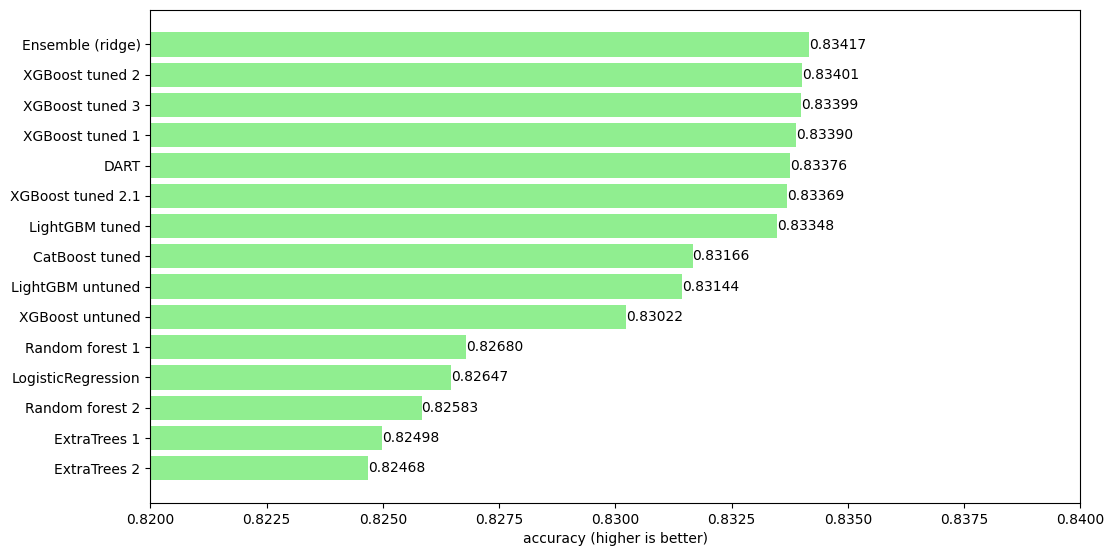

In [215]:
result_list = []
for label in oof.keys():
    score = accuracy_score(targets, np.argmax(oof[label], axis=1))
    result_list.append((label, score))
result_df = pd.DataFrame(result_list, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=False)

plt.figure(figsize=(12, len(result_df) * 0.4 + 0.4))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color='lightgreen')
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.gca().invert_yaxis()
plt.xlim(0.82, 0.84)
plt.xlabel(f'accuracy (higher is better)')
plt.show()

In [219]:
if compute_test_pred:
    print(result_df.label.iloc[0])
    pred = np.argmax(test_pred[result_df.label.iloc[0]], axis=1)
    pred = label_encoder.inverse_transform(pred)
    sub = pd.Series(pred, index=df_test.index, name='Target')
    filename = 'submission.csv'
    sub.to_csv(filename)
    os.system(f"head {filename}")
    
    print('\nEnsemble (ridge)')
    pred = np.argmax(test_pred['Ensemble (ridge)'], axis=1)
    pred = label_encoder.inverse_transform(pred)
    sub = pd.Series(pred, index=df_test.index, name='Target')
    filename = 'submission_ensemble_ridge.csv'
    sub.to_csv(filename)
    os.system(f"head {filename}")
    
    print('\nEnsemble (logistic)')
    pred = np.argmax(test_pred['Ensemble (logistic)'], axis=1)
    pred = label_encoder.inverse_transform(pred)
    sub = pd.Series(pred, index=df_test.index, name='Target')
    filename = 'submission_ensemble_logistic.csv'
    sub.to_csv(filename)
    os.system(f"head {filename}")

Ensemble (ridge)
id,Target
76518,Dropout
76519,Graduate
76520,Graduate
76521,Graduate
76522,Enrolled
76523,Graduate
76524,Graduate
76525,Graduate
76526,Dropout

Ensemble (ridge)
id,Target
76518,Dropout
76519,Graduate
76520,Graduate
76521,Graduate
76522,Enrolled
76523,Graduate
76524,Graduate
76525,Graduate
76526,Dropout

Ensemble (logistic)
id,Target
76518,Dropout
76519,Graduate
76520,Graduate
76521,Graduate
76522,Enrolled
76523,Graduate
76524,Graduate
76525,Graduate
76526,Dropout
